# Settings

In [1]:
%matplotlib inline

In [2]:
# Ajustes generales para los gráficos
from distutils.spawn import find_executable

from matplotlib.font_manager import *
from matplotlib.collections import *
from matplotlib.patches import *
from matplotlib.pylab import *
from matplotlib import colors

import seaborn
import gc

ioff()

rc('lines', linewidth=1)
rc('font', family='serif')

if find_executable('latex'):
    rc('text', usetex=True)

# Minor Third Type Scale
scale_factor = 1.2
base_font_size = 12

font_title = FontProperties(size=base_font_size*(scale_factor**2))
font_label = FontProperties(size=base_font_size*(scale_factor**1))
font_legend = FontProperties(size=base_font_size*(scale_factor**0))
font_ticks = FontProperties(size=base_font_size*(scale_factor**-1))

seaborn.set(context='notebook', style='darkgrid')

# Raw Data

In [3]:
from scf import get_data

raw_data = get_data()

# Dayli Records

In [4]:
from scf import parse_data
from collections import OrderedDict
from pandas import DataFrame
from numpy import nan

headers = ['Date', 'SN value', 'SN error', 'Flag']

daily = list(zip(*map(parse_data, raw_data)))
daily = DataFrame(OrderedDict(zip(headers, daily))).replace(-1.0, nan)
daily = daily.set_index(["Date"], drop=True)

In [5]:
nan_locations = where(isnan(daily['SN value'].values))
nan_locations

(array([    0,     1,     2, ..., 11307, 11310, 11313]),)

# Monthly Average

In [29]:
from scf import agg_mean
from scf import agg_std
from scf import agg_quadsum
from scf import agg_all
from pandas import Timestamp

monthly = daily.groupby([lambda x: x.year, lambda x: x.month])

# BEGIN:
# Groups analysis
# Detecting nans in groups
print(">>> NAN entries")
for key in monthly.groups:
    average_group = agg_mean(daily.loc[monthly.groups[key]]['SN value'])
    if isnan(average_group):
        print(key, average_group)
# END

monthly = monthly.agg({
    'SN value': [agg_mean, agg_std],
    'SN error': agg_quadsum,
    'Flag': [all]
})

# Flattening labels
monthly.columns = [
    'Monthly SN mean', 'Monthly SN std', 'Monthly SN erros', 'Flag'
]

# Flattening indexes
monthly.index = [Timestamp(y, m, 1) for y, m in monthly.index.values]

>>> NAN entries
(1824, 2) nan


In [30]:
span = 2

nan_locations = where(isnan(monthly['Monthly SN mean'].values))
print(">>> NAN locations")
print(nan_locations)
print()

print(">>> NAN entries")
for locs in nan_locations:
    for j in locs:
        print((monthly.iloc[j].name.year, monthly.iloc[j].name.month), monthly.iloc[j].values[0])

>>> NAN locations
(array([73]),)

>>> NAN entries
(1824, 2) nan


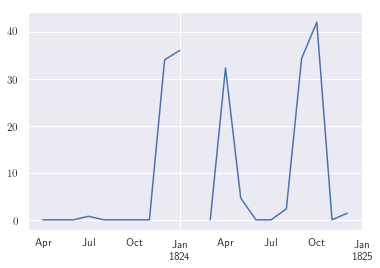

In [31]:
span = 10
monthly.iloc[73-span:73+span+1]['Monthly SN mean'].plot()
show()
close('all')

# Smooth Monthly Average

In [32]:
monthly.iloc[:7]

,Monthly SN mean,Monthly SN std,Monthly SN erros,Flag
1818-01-01,58.125000,30.807619,27.337154,False
1818-02-01,37.428571,52.760529,29.329166,False
1818-03-01,42.357143,23.699328,30.943982,False
1818-04-01,57.523810,18.783526,43.964872,False
1818-05-01,88.480000,47.014993,59.582800,False
1818-06-01,60.800000,29.733483,49.397571,False
1818-07-01,46.761905,18.700407,39.665728,False


In [53]:
# from scf import weighted_average

def weighted_average(w):
    def average(x):
        # print(x)
        if len(x) < len(w):
            return nan

        return nansum(w * x)

    return average

w = array([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1])
w = w/sum(w)

# Deleting unnused colums
smooth = monthly.copy()
smooth.drop('Monthly SN std', 1, inplace=True)
smooth.drop('Monthly SN erros', 1, inplace=True)
smooth.drop('Flag', 1, inplace=True)

smooth = smooth.rolling(window=13, min_periods=0, center=True)

In [54]:
smooth = smooth.apply(weighted_average(w), raw=False).iloc[6:-6]

# Renaming columns
smooth.columns = ['Smooth SN mean']

In [55]:
nan_locations = where(isnan(smooth['Smooth SN mean'].values))
nan_locations

(array([], dtype=int64),)

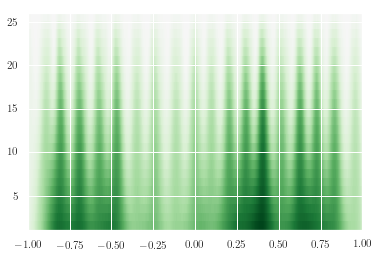

In [57]:
from scipy import signal
# import matplotlib.pyplot as plt
t = smooth.index.to_pydatetime()
sig  = smooth['Smooth SN mean'].values
sig[isnan(sig)] = 0
widths = arange(1, 26)
cwtmatr = signal.cwt(sig, signal.barthann, widths)

imshow(cwtmatr, extent=[-1, 1, 1, 26], cmap='PRGn', aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
show()

In [58]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5390563276754433998
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 949354496
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12839071947221007663
physical_device_desc: "device: 0, name: GeForce 940MX, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [59]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [60]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [61]:
numpy.random.seed(1000)

In [62]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [65]:
dataset = smooth.copy()
dataset

,Smooth SN mean
1818-07-01,49.982684
1818-08-01,49.720730
1818-09-01,48.098861
1818-10-01,45.603822
1818-11-01,42.284998
1818-12-01,39.851405
1819-01-01,39.983306
1819-02-01,39.842185
1819-03-01,38.689446
1819-04-01,37.629541


In [66]:
dataset = scaler.fit_transform(dataset)
dataset

array([[0.17496495],
       [0.17404534],
       [0.16835169],
       ...,
       [0.04355873],
       [0.03416706],
       [0.02706889]])

In [229]:
TRAIN_SIZE = 0.60

train_size = int(len(dataset) * TRAIN_SIZE)
test_dataset = dataset[0:train_size,:]

test_size = len(dataset) - train_size
train_dataset = dataset[train_size:len(dataset),:]

print("NData Train:", len(train))
print("NData Test :", len(test))

NData Train: 1606
NData Test : 792


In [230]:
shape(dataset[:5])

(5, 1)

In [231]:
def create_dataset(dataset, look_back=1):
    dataX = dataset[0:-look_back-1].reshape(dataset[0:-look_back-1].shape[0],1,1)
    dataY = squeeze(dataset[1:-look_back])
    return dataX, dataY
    # dataX, dataY = [], []
    # for i in range(len(dataset)-look_back-1):
    #     a = dataset[i:(i+look_back), 0]
    #     dataX.append(a)
    #     dataY.append(dataset[i + look_back, 0])
    # return numpy.array(dataX), numpy.array(dataY)

In [232]:
look_back = 1
trainX, trainY = create_dataset(train_dataset, look_back)
# print(shape(trainX))
# trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
print(shape(trainX))

(958, 1, 1)


In [233]:
look_back = 1
testX, testY = create_dataset(test_dataset, look_back)
# print(shape(testX))
# testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(shape(testX))

(1436, 1, 1)


In [ ]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 5s - loss: 0.0340
Epoch 2/100
 - 5s - loss: 0.0013
Epoch 3/100
 - 5s - loss: 2.4839e-04
Epoch 4/100
 - 6s - loss: 2.4748e-04
Epoch 5/100
 - 6s - loss: 2.5608e-04
Epoch 6/100
 - 7s - loss: 2.6030e-04
Epoch 7/100
 - 7s - loss: 2.6337e-04
Epoch 8/100
 - 7s - loss: 2.6794e-04
Epoch 9/100
 - 7s - loss: 2.5993e-04
Epoch 10/100
 - 7s - loss: 2.6067e-04
Epoch 11/100
 - 7s - loss: 2.6042e-04
Epoch 12/100
 - 7s - loss: 2.6928e-04
Epoch 13/100
 - 7s - loss: 2.6326e-04
Epoch 14/100
 - 7s - loss: 2.6317e-04
Epoch 15/100


(790, 1, 1)
Train Score: 4.38 RMSE


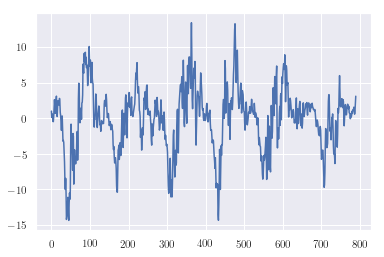

In [167]:
# make predictions
print(shape(trainX))
trainPredict = model.predict(trainX)
trainPredict = scaler.inverse_transform(trainPredict)

trainTrue = scaler.inverse_transform([trainY])

trainScore = math.sqrt(mean_squared_error(trainTrue[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

# plot(trainPredict)
# plot(squeeze(trainX)+1)
# show()
# plot(squeeze(trainPredict)[1:] - squeeze(trainY)[:-1])
# show()
# plot(squeeze(trainPredict)[:-1] - squeeze(trainY)[1:])
# show()
plot(squeeze(trainPredict) - squeeze(trainTrue))
show()

(1604, 1, 1)
Test Score: 3.96 RMSE


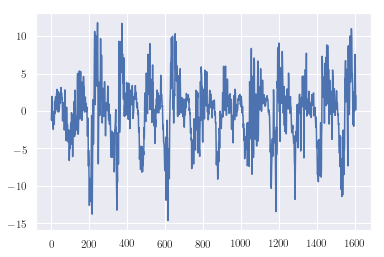

In [168]:
print(shape(testX))
testPredict = model.predict(testX)
testPredict = scaler.inverse_transform(testPredict)

testTrue = scaler.inverse_transform([testY])

testScore = math.sqrt(mean_squared_error(testTrue[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# plot(testPredict)
# plot(squeeze(testX)+1)
# show()
# plot(squeeze(testPredict)[1:] - squeeze(testY)[:-1])
# show()
# plot(squeeze(testPredict)[:-1] - squeeze(testY)[1:])
# show()
plot(squeeze(testPredict) - squeeze(testTrue))
show()

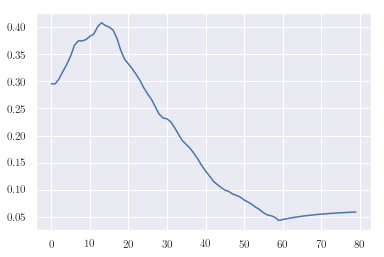

In [204]:
X, Y = create_dataset(dataset, look_back)
X = numpy.reshape(X, (X.shape[0], 1, X.shape[1]))
P = X

future = list(squeeze(X)[-60:])

# print(">>> Start")
# print("X:", squeeze(X)[-5:])
# print("Y:", squeeze(Y)[-5:])

for i in range(20):
    P = model.predict(P)
    P = numpy.reshape(P, (P.shape[0], 1, P.shape[1]))
    future.append(squeeze(P)[-1])

    # print(">>> Prediction", i)
    # print("P:", squeeze(P)[-5:])

plot(future)
show()

In [ ]:
futureElements

In [ ]:
fig = figure(figsize=(8.5, periods*1.5), frameon=False)
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
original_dataset = scaler.inverse_transform(dataset)
plt.plot(original_dataset, label="series", lw=1)
plt.plot(trainPredictPlot+100, label="train", lw=1)
plt.plot(testPredictPlot+200, label="test", lw=1)
# plt.plot(squeeze(realPredict)+300, label="real", lw=1)
# plt.plot(300, label="real", lw=1)
plt.legend()
fig.tight_layout()
plt.show()

In [ ]:
test_predict = smooth
test_predict['Smooth SN mean'].values[6:-6] = squeeze(testPredictPlot)

In [ ]:
train_predict = smooth
train_predict['Smooth SN mean'].values[6:-6] = squeeze(trainPredictPlot)

In [ ]:
original_dataset = smooth

In [ ]:
from pandas import Timedelta

yearDelta = 60
periods = (smooth.index[-1].year - smooth.index[0].year) / yearDelta
periods = ceil(periods)
periods = int(periods)

fig = figure(figsize=(8.5, periods * 3), frameon=False)

title = r"$\mathrm{Promedio\ suavizado\ del\ N\acute{u}mero\ Manchas\ Solares}$"

y_liml = 0
y_limu = ceil(nanmax(smooth['Smooth SN mean']) / 100.0) * 100

d_yticks = 100
n_yticks = int((y_limu - y_liml) / d_yticks)
t_yticks = [y_liml + i * d_yticks for i in range(n_yticks + 1)]
l_yticks = [r"${0:>3}$".format(y) for y in t_yticks]

y_label = r"$\mathrm{ISN}$"

for i in range(periods):
    axs = fig.add_subplot('{0:.0f}1{1:.0f}'.format(periods, i + 1))

    x_liml = Timestamp(smooth.index[0].year + i * yearDelta, 1, 1)
    x_limu = Timestamp(smooth.index[0].year + (i + 1) * yearDelta - 1, 12, 31)

    plotData = smooth[x_liml:x_limu]

    if i == 0:
        nanStop = 0
        nanStop = where(isnan(daily['SN value']))[0][-1] + 1
        nanStop = daily.index[nanStop]
        nanStop = plotData[:nanStop].index[-1]

        graph, = plot(
            plotData['Smooth SN mean'][:nanStop],
            color='red',
            linewidth=0.5,
            antialiased=True,
            label=(r"$\mathrm{A\tilde{n}os\ con\ }$" +
                   r"$\mathrm{registros\ incompletos\ }$" +
                   r"$({0:}-{1:})$".format(plotData.index[0].year,
                                           plotData[:nanStop].index[-1].year)))

        graph, = plot(
            plotData['Smooth SN mean'][nanStop:],
            color='blue',
            linewidth=0.5,
            antialiased=True,
            label=(
                r"$\mathrm{A\tilde{n}os\ con\ }$" +
                r"$\mathrm{registros\ completos\ }$" + r"$({0:}-{1:})$".format(
                    plotData[nanStop:].index[0].year + 1,
                    daily.index[-1].year)))

        axs.set_title(title, fontproperties=font_title)
        axs.title.set_position([.5, 1.30])

        axs.legend(
            loc='upper center',
            bbox_to_anchor=(0.5, 1.25),
            ncol=3,
            borderaxespad=0.0,
            prop=font_legend)
    else:
        plot(
            plotData['Smooth SN mean'],
            color='blue',
            linewidth=0.5,
            antialiased=True)

    axs.set_ylim([y_liml, y_limu])
    axs.set_yticks(t_yticks)
    axs.set_yticklabels(l_yticks, fontproperties=font_ticks)
    axs.set_ylabel(y_label, fontproperties=font_label)

    n_xticks = int(yearDelta / 10)
    d_xticks = ceil(
        (x_limu.year - (x_liml + Timedelta(1, 'd')).year) / n_xticks)
    t_xticks = [
        Timestamp(int(x_liml.year + i * d_xticks), 1, 1)
        for i in range(n_xticks + 1)
    ]
    l_xticks = [
        r"${1:>4}$-${0:0>2}$".format(x.month, x.year) for x in t_xticks
    ]

    axs.set_xlim([x_liml, x_limu + Timedelta(1, 'd')])
    axs.set_xticks(t_xticks)
    axs.set_xticklabels(l_xticks, fontproperties=font_ticks)

    axs.grid(color='#ffffff', linestyle='-')

x_label = r"$\mathrm{Fecha}$"
axs.set_xlabel(x_label, fontproperties=font_label)
fig.tight_layout()
show()

In [ ]:
close('all')

In [209]:
a = array([1,2,3,4,4,5])
a.reshape(a.shape[0], 1, 1)

array([[[1]],

       [[2]],

       [[3]],

       [[4]],

       [[4]],

       [[5]]])

In [210]:
a.reshape(a.shape[0], 1)

array([[1],
       [2],
       [3],
       [4],
       [4],
       [5]])